# Under- and overfitting, model selection

## Preliminaries

In the first set of exercises you had to implement the training and evaluation of the linear regression and $k$-NN methods from scratch in order to practice your `numpy` skills. From this set of exercises onward, you can use the implementations provided in `scikit-learn` or other higher-level libraries. We start this set of exercises by demonstrating some of the features of `scikit-learn`.

For example, implementation of linear regression model fitting with an analytical solution for the parameters is provided by the class `sklearn.linar_model.LinearRegression`. You can train a linear regression model in the following way:

In [1]:
import numpy as np
from sklearn import datasets, linear_model

# load the diabetes dataset
diabetes = datasets.load_diabetes()

# use only one feature
X = diabetes.data[:, np.newaxis, 2]
y = diabetes.target

# split the data into training/testing sets
X_train = X[:-20]
X_test = X[-20:]

# split the targets into training/testing sets
y_train = y[:-20]
y_test = y[-20:]

# create linear regression object
model = linear_model.LinearRegression()

# train the model using the training dataset
model.fit(X_train, y_train)

LinearRegression()

Let's visualize the training dataset and the learned regression model.

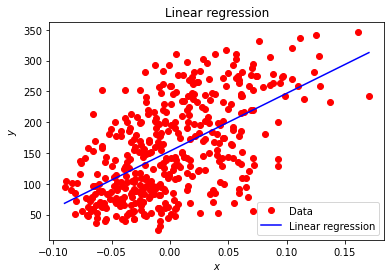

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(X_train, y_train, 'r.', markersize=12)
X_edge = np.array([np.min(X_train, 0), np.max(X_train, 0)])
plt.plot(X_edge, model.predict(X_edge), 'b-')
plt.legend(('Data', 'Linear regression'), loc='lower right')
plt.title('Linear regression')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

Once trained, the model can be used to make predictions on the test data:

In [3]:
# Make predictions using the testing dataset
prediction = model.predict(X_test)

The next step (not shown here) is to evaluate the performance of the trained model.

Note that the `scikit-learn` interface works by first initializing an object from the class that implements the machine learning model (linear regression in this case) and then fitting the initialized model using the data in the training set. Finally, the trained (fitted) model can be used to make predictions on unseen data. In fact, all models implemented in this library follow the same *initialize-fit-predict* programming interface. For example, a $k$-NN classifier can be trained in the following way:

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, neighbors

breast_cancer = datasets.load_breast_cancer()

X = breast_cancer.data
y = breast_cancer.target

# make use of the train_test_split() utility function instead
# of manually dividing the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=40)

# initialize a 3-NN classifier
model = neighbors.KNeighborsClassifier(n_neighbors=3)

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)

Note that the features in the breast cancer dataset have different scales (some have on average very small absolute values, and some very large), which means that the distance metric used by $k$-NN will me dominated by the features with large values. You can use any of the number of feature transformation methods implemented in `scikit-learn` to scale the features. For example, you can use the `sklearn.preprocessing.StandardScaler` method to transform all features to a have a zero mean and unit variance:

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)

The scaler has its own parameters which are the means and standard deviations of the features estimated from the training set. If you train a model with the scaled features, you will have to remember to also apply the scaling transformation every time you make a prediction on new unseen and unscaled data. This is somewhat prone to error. One option for making the code more robust is to create a processing pipeline that includes the scaling and $k$-NN models in a sequence:

In [6]:
from sklearn.pipeline import Pipeline

knn = neighbors.KNeighborsClassifier(n_neighbors=3)

model = Pipeline([
                 ("scaler", scaler),
                 ("knn", knn)
                ])

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)


If you are curious, more information about the design of the `scikit-learn` application programming interface (API) can be found [in this paper](https://arxiv.org/pdf/1309.0238.pdf). 

## Exercises

### Bias-variance decomposition

Show that the mean squared error of the estimate of a parameter can be decomposed into an expression that includes both the bias and variance (Eq. 5.53-5.54 in "Deep learning" by Goodfellow et al.). 

First the equations for variance and bias need to be written out. The estimate of the sample is denoted with $\hat{\theta_s}$. 

$Var(\hat{\theta_s}) = 𝔼[(\hat{\theta_s} - 𝔼[\hat{\theta_s}])^2] $ <br>
$= 𝔼[\hat{\theta_s}^2 - 2\hat{\theta_s}𝔼[\hat{\theta_s}] + 𝔼[\hat{\theta_s}]^2] $ <br>
$= 𝔼[\hat{\theta_s}^2] - 2𝔼[\hat{\theta_s}]𝔼[\hat{\theta_s}] + 𝔼[\hat{\theta_s}]^2 $ <br>
$= 𝔼[\hat{\theta_s}^2] - 𝔼[\hat{\theta_s}]^2 $ <br>

$Bias(\hat{\theta_s}) = 𝔼[\hat{\theta_s} - \theta] = 𝔼[\hat{\theta_s}] - \theta $

So now that the variance and bias are written out, the mean squared error needs te be written out.

$MSE = 𝔼[(\hat{\theta_s}-\theta)^2] $ <br>
$= 𝔼[\hat{\theta_s}^2] - 2\theta𝔼[\hat{\theta_s}] + \theta^2 $

As can be seen, a $2\theta𝔼[\hat{\theta_s}]$ is needed, which can be assessed by squaring the bias. 

$Bias^2(\hat{\theta_s}) = 𝔼[\hat{\theta_s}^2] - 2\theta𝔼[\hat{\theta_s}] + \theta^2 $

If the variance and squared bias are added, it results in the following:

$Variance + Bias^2 = 𝔼[\hat{\theta_s}^2] - 𝔼[\hat{\theta_s}]^2 + 𝔼[\hat{\theta_s}^2] - 2\theta𝔼[\hat{\theta_s}] + \theta^2$ <br>
$= 𝔼[\hat{\theta_s}^2] - 2\theta𝔼[\hat{\theta_s}] + \theta^2$

This is equal to the mean squared error. 

### Polynomial regression

For this exercise we will be using generated data to better show the effects of the different polynomial orders.
The data is created using the make_polynomial_regression function.

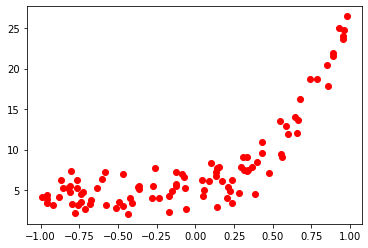

In [7]:
%matplotlib inline

def generate_dataset(n=100, degree=1, noise=1, factors=None):
    # Generates a dataset by adding random noise to a randomly
    # generated polynomial function.
    
    x = np.random.uniform(low=-1, high=1, size=n)
    
    factors = np.random.uniform(0, 10, degree+1)
    
    y = np.zeros(x.shape)
    
    for idx in range(degree+1):
        y += factors[idx] * (x ** idx)

    # add noise
    y += np.random.normal(-noise, noise, n)
    
    return x, y

# load generated data
np.random.seed(0)

X, y = generate_dataset(n=100, degree=4, noise=1.5)

plt.plot(X, y, 'r.', markersize=12);

Implement polynomial regression using the `sklearn.preprocessing.PolynomialFeatures` transformation. Using the `sklearn.grid_search.GridSearchCV` class, perform a grid search of the polynomial order hyperparameter space with cross-validation and report the performance on an independent test set.

The optimal polynomial order is 7


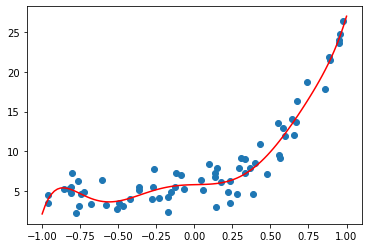

In [8]:
# import libraries
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

# split the dataset in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# create pipeline and fitting it on data
from sklearn.pipeline import Pipeline
plt.scatter(X_train,y_train)

# create model, find parameters and fit model to training data
model = make_pipeline(StandardScaler(), PolynomialFeatures(), LinearRegression())
parameters = {'polynomialfeatures__degree': np.arange(1, 10)}

gscv = GridSearchCV(model, parameters, cv = 10, scoring='neg_mean_squared_error')
gscv.fit(X_train.reshape(-1,1),y_train)

# plot data points and polynomial of optimal order
space = np.linspace(-1,1,101).reshape(-1,1)
est_deg= gscv.best_params_['polynomialfeatures__degree']
plt.plot(space, gscv.predict(space), color = 'red')
print('The optimal polynomial order is {}'.format(est_deg))

#Source: https://stats.stackexchange.com/questions/453781/how-do-you-determine-what-degree-of-polynomial-to-fit-to-data

Plot a learning curve that show the validation accuracy as a function of the polynomial order.     

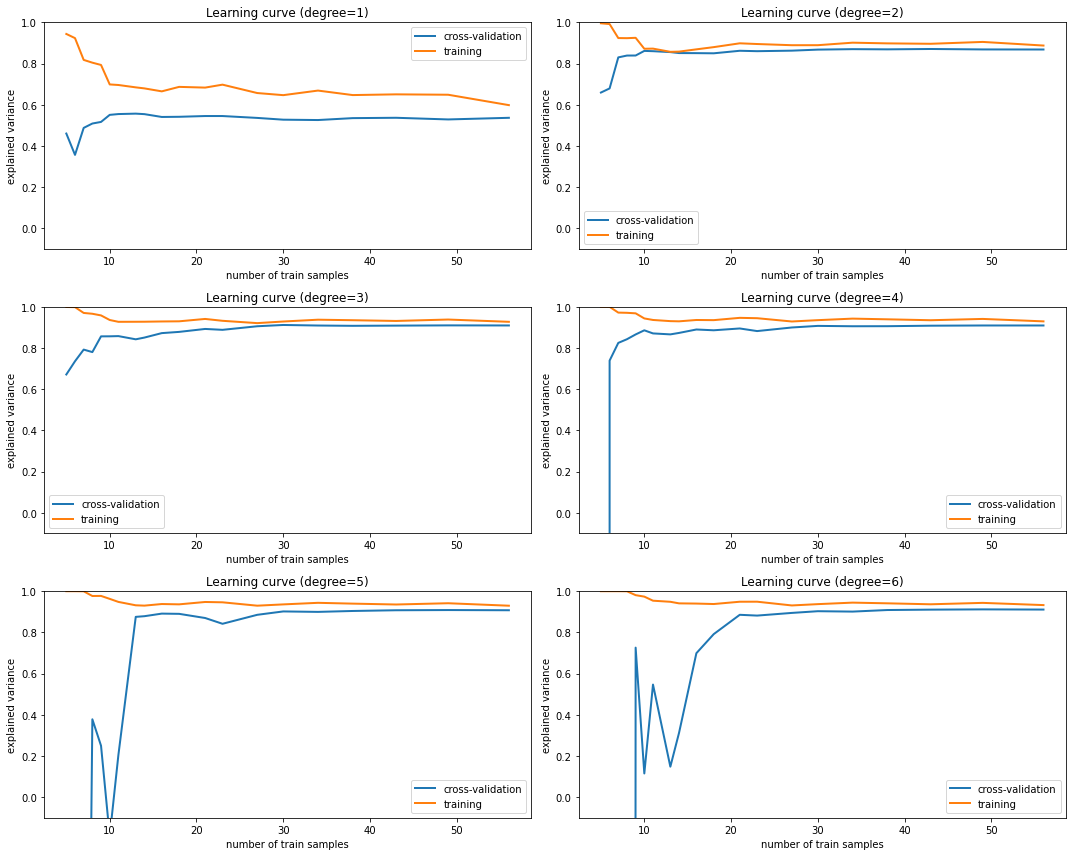

In [9]:
#plot learning curves for polynomial degrees 1-6.

fig, axs = plt.subplots(3,2,figsize=(15, 12))
axs = axs.flatten()
for d in [1, 2, 3, 4, 5, 6]:
    model = make_pipeline(PolynomialFeatures(degree=d), LinearRegression())

    from sklearn.model_selection import learning_curve
    train_sizes, train_scores, validation_scores = learning_curve(
        model, X_train[:, np.newaxis], y_train,
        train_sizes=np.logspace(-1, 0, 20))

    #plot the mean train error and validation error across folds
   
    axs[d-1].plot(train_sizes, validation_scores.mean(axis=1),
            lw=2, label='cross-validation')
    axs[d-1].plot(train_sizes, train_scores.mean(axis=1),
                lw=2, label='training')
    axs[d-1].set_ylim(ymin=-.1, ymax=1)

    axs[d-1].legend(loc='best')
    axs[d-1].set_xlabel('number of train samples')
    axs[d-1].set_ylabel('explained variance')
    axs[d-1].set_title('Learning curve (degree=%i)' % d)
    

plt.tight_layout()
plt.show()

<p><font color='#770a0a'>Which models have a high bias, and which models have high variance? Motivate your answer.</font><p>
    
The model with polynomial degree = 1 has the least bias because it has the lowest training error. The large gap between the training and validation curve indicates a high variance, which is the largest for the model with degree = 1 for n > 10. However, for n < 10 it is the largest for the higher polynomial degrees.

To plot the learning curve for the validation accuracy as a function of the polynomial order, n = 30 is chosen because for that  number of training samples and higher, the cross-validation explained variance is stable for all polynomial degrees. 
So in the code below, the validation accuracy is plotted against the polynomial degree for n = 30. 

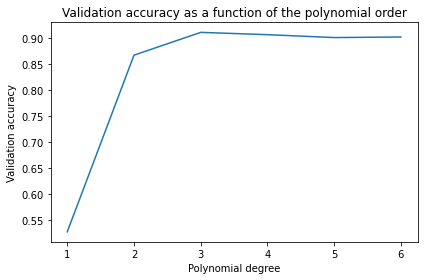

In [10]:
# import libraries
from sklearn.model_selection import learning_curve

# compute mean accuracy for each polynomial degrees and save this mean in a list
validation_values = []
degrees = range(1, 7) # Range of polynomial degrees that are tested

for d in degrees:
    model = make_pipeline(PolynomialFeatures(degree=d), LinearRegression())

    train_sizes, train_scores, validation_scores = learning_curve(
        model, X_train[:, np.newaxis], y_train, train_sizes=[30])
    validation = sum(validation_scores[0])/len(validation_scores[0]) # Take the mean of all validation scores of the cross-validation
    validation_values.append(validation) # Append the validation score for this polynomial degree to the list of all validations

# plot validation accuracy of each polynomial degree
plt.figure(figsize=(6, 4))
plt.plot(degrees, validation_values)
plt.xlabel('Polynomial degree')
plt.ylabel('Validation accuracy')
plt.title('Validation accuracy as a function of the polynomial order')
plt.tight_layout()
plt.show()

Repeat this experiment, this time using the diabetes dataset instead of the generated data.

The optimal polynomial order is 1.


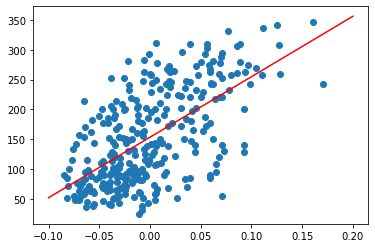

In [11]:
# load the diabetes dataset
diabetes = datasets.load_diabetes()

# use only one feature
X = diabetes.data[:, np.newaxis, 2]
y = diabetes.target

# split the dataset in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# create pipeline and fitting it on data
from sklearn.pipeline import Pipeline
plt.scatter(X_train,y_train)

# create model, find parameters and fit model to training data
model = make_pipeline(StandardScaler(), PolynomialFeatures(), LinearRegression())
parameters = {'polynomialfeatures__degree': np.arange(1, 10)}

gscv = GridSearchCV(model, parameters, cv = 10, scoring='neg_mean_squared_error')
gscv.fit(X_train.reshape(-1,1),y_train)

# plot data point and polynomial of optimal order
space = np.linspace(-0.1,0.2,101).reshape(-1,1)
est_deg= gscv.best_params_['polynomialfeatures__degree']
print('The optimal polynomial order is {}.'.format(est_deg))
plt.plot(space, gscv.predict(space), color = 'red');


### ROC curve analysis
A common method to evaluate binary classifiers is the receiver operating characteristic (ROC) curve. Similar to the week one practicals, implement a $k$-NN classifier on the breast cancer dataset, however, his time use the $k$-NN pipeline from the preliminary. Train the model for different values of $k$ and evaluate their respective performance with an ROC curve, use the `sklearn.metrics.roc_curve` function.


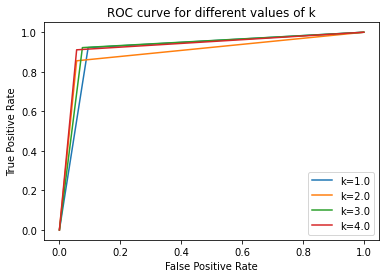

In [12]:
from sklearn.metrics import roc_curve

# load dataset
X = breast_cancer.data
y = breast_cancer.target

# divide dataset into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=40)

range_K = range(1,5) # select different values of k
fpr = dict() # false predicted
tpr = dict() # true predicted

# loop of different values of k and calculate fpr and tpr
for K in range_K:
    model = neighbors.KNeighborsClassifier(n_neighbors=K)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    fpr[K],tpr[K], _ = roc_curve(y_test,prediction)
    
# plot roc curve for different values of k
for K in range_K:
    plt.plot(fpr[K], tpr[K], label = 'k=%0.1f'%K)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for different values of k')
plt.legend();

An ROC curve is a graph of the true positive rate (sensititvity) against the false negative rate (1-specificity). It depends on the case whether you want more true positives and accept more false false positves. In the case of breast cancer you want to select as many true positives as possible and it is less important if the false positive rate is higher. Therefore it is desired to choose the k-value for which the corner is most to the upper right. Which is the case for k=4. In this situation and range of k-values k=2 is the least optimal model since this corner is lower and therefore results in a lower true positive rate. 

### $F_1$ score and Dice similarity coefficient

The Dice similarity coefficient is a very popular evaluation measure for image segmentation applications. Assuming that $A$ is the ground truth segmentation of an object represented as a binary image, and $B$ is the binary output of an image segmentation method, the Dice similarity coefficient is computed as:

$\text{Dice}(A,B) = \frac{2|A\cap B|}{|A| + |B|}$

where $|\cdot|$ represents the cardinality of the objects (e.g. $|A|$ is the number of non-zero pixels in the ground truth segmentation).

For example, the Dice similarity can be computed in the following way:

0.3402777777777778


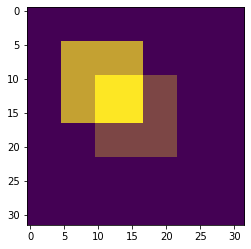

In [13]:
# generate some test objecys
A = np.zeros((32, 32))
A[10:-10, 10:-10] = 1
B = np.zeros((32, 32))
B[5:-15, 5:-15] = 1

dice = 2*np.sum(A*B)/(np.sum(A)+np.sum(B))

# display the results
plt.plot()
plt.imshow(A)
plt.imshow(B, alpha=0.7)

print(dice)

<p><font color='#770a0a'>Show that the $F_1$ score, which is the harmonic mean of precision and recall, is equivalent to the Dice similarity coefficient</font><p>
    

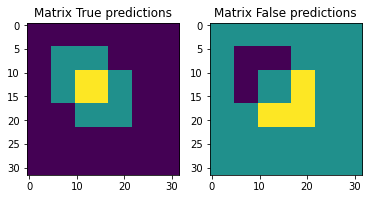

In [14]:
# create the sum and the difference between matrix A and B for calculation of the True/False positives/negatives
mat_T = A + B # matrix for True positive/negative determination
mat_F = A - B # matric for False positive/negative determination

# plot the two newly created matrices
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(mat_T)
ax2.imshow(mat_F)
ax1.set_title("Matrix True predictions")
ax2.set_title("Matrix False predictions")

# count the number of occurences of -1, 0 and 1 for both matrices
unique_T, counts_T = np.unique(mat_T, return_counts=True) #-1 = TN, 0 = FN/FP, 1= TP
unique_F, counts_F = np.unique(mat_F, return_counts=True) #-1 = FN, 0 = TN/FN, 1= FP

TP = counts_T[2] # true positives
TN = counts_T[0] # true negatives
FP = counts_F[2] # false positives
FN = counts_F[0] # false negatives

In [15]:
Precision = TP/(TP+FP)  # calculate precision
Recall = TP/(TP+FN)     # calculate recall
F1 = 2*(Precision*Recall)/(Precision+Recall) # calculate F1 score

In [16]:
# check if the dice coefficient and the F1 score result in the same value
if F1 == dice:
    print("Yes, the F1 score, also known as the harmonic mean of the precision and the recall, is equivalent to the Dice similarity coefficient!")
else:
    print("No, the F1 score is not equivalant to the Dice similarity coefficient!")

Yes, the F1 score, also known as the harmonic mean of the precision and the recall, is equivalent to the Dice similarity coefficient!
